# 2D Regression with a DNN Splitting the Database

We'll implement a script to regress 2D data using a two-layer dense neural network trained splitting the database between training set, validation set, and test set.

## Load Data

We load the data using the function `load_data()` contained in `loader.py`.

In [1]:
from loader import load_data

(x, y_gt) = load_data(filename="data_reg_2d_nonlinear.csv")

print("x:", x)
print("y_gt:", y_gt)

x: [[-0.2224211  -0.15564462]
 [ 0.65675937  0.53032608]
 [ 0.21597372  0.57542981]
 [ 0.0472221  -0.08081086]
 [ 0.02184948 -0.05671952]
 [ 0.39099227 -0.37932797]
 [-1.27367568 -0.34172716]
 [ 0.37215329 -0.74583882]
 [-0.01044955  1.19439785]
 [-1.29713475  1.24549235]
 [-1.02855559 -1.48320358]
 [ 0.45099998 -0.75056005]
 [ 0.03685162 -0.66335451]
 [ 1.55966194 -2.45834961]
 [-0.07402267 -1.13765725]
 [ 2.05966154  2.10391695]
 [ 0.16893866  1.06634604]
 [-0.24129401 -0.42943993]
 [-1.00245756  0.04010673]
 [-0.5273956  -0.91670649]
 [-0.49435188  1.34816325]
 [ 1.85039308  0.52347435]
 [-0.10394141 -1.35018048]
 [-0.88089055  1.42690126]
 [ 0.08176963 -2.15782374]
 [-1.05339772 -0.05170006]
 [ 0.15367086 -1.92569791]
 [-1.22395047 -0.42954738]
 [ 0.03710187 -1.36820513]
 [ 1.0630793   0.02247431]
 [-1.03096003  0.39161347]
 [ 0.07131787 -0.5749716 ]
 [ 0.46953539 -1.38237299]
 [-0.11606302 -0.34084266]
 [ 1.50326854  0.34406896]
 [-0.5641367  -0.29503353]
 [ 0.75829488 -0.79417023

## Splitting Datasets



In [2]:
from numpy import split, delete
from numpy.random import choice

num_samples = len(x)
split = .70

num_samples_train = int(split * num_samples)
train_idx = choice(num_samples, num_samples_train, replace=False)

x_train = x[train_idx] # train inputs
y_gt_train = y_gt[train_idx] # train groundtruths

x_val = delete(x, train_idx, axis=0) # validation inputs
y_gt_val = delete(y_gt, train_idx, axis=0) # validation groundtruths

print(f"{len(x_train)} training datapoints")
print(f"{len(x_val)} validation datapoints")

35 training datapoints
15 validation datapoints


## Two-Layer Neural Network

We now create the two-layer neural network with 10 neurons (`num_neuron = 10``) in the first layer and a single neuron in the output layer ...

In [3]:
num_neurons = 10

def sigmoid(x):
    from numpy import exp
    return 1 / (1 + exp(-x))

def dnn2_reg(wa, wb, x):
    return sigmoid(x @ wa) @ wb

... randomly initialize its weights ...

In [4]:
from numpy.random import default_rng

rng = default_rng()
wa = rng.standard_normal(size=(2, num_neurons)) # input weights layer 1
wb = rng.standard_normal(size=(num_neurons, 1)) # input weights layer 2 (output)

... and obtain its predictions for the training and validation data.

In [5]:
y_p_train = dnn2_reg(wa, wb, x_train)
y_p_val = dnn2_reg(wa, wb, x_val)

## Visualize Predictions by Randomly Initialized Neural Network

We now plot the data and predictions using the functions `plot_pred_2d` and `plot_pred_vs_gt()` from `plotting.py`.

For the training set:

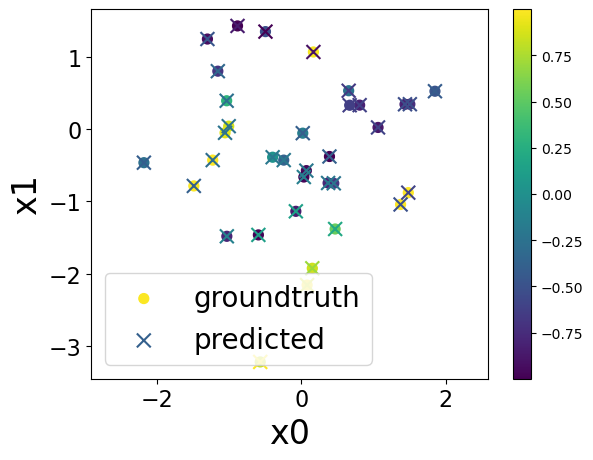

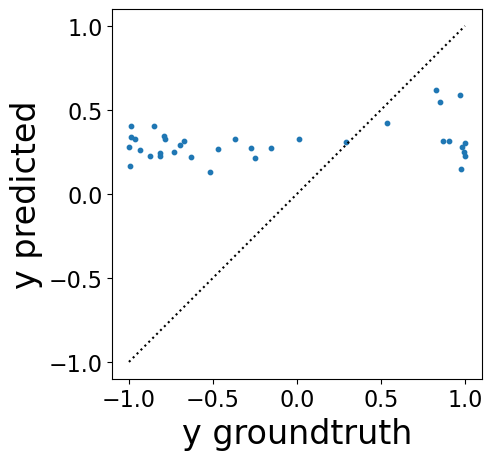

In [6]:
from plotting import plot_pred_2d, plot_pred_vs_gt

plot_pred_2d(x_train, y_gt_train, y_p_train)
plot_pred_vs_gt(y_gt_train, y_p_train)

... and for the validation set.

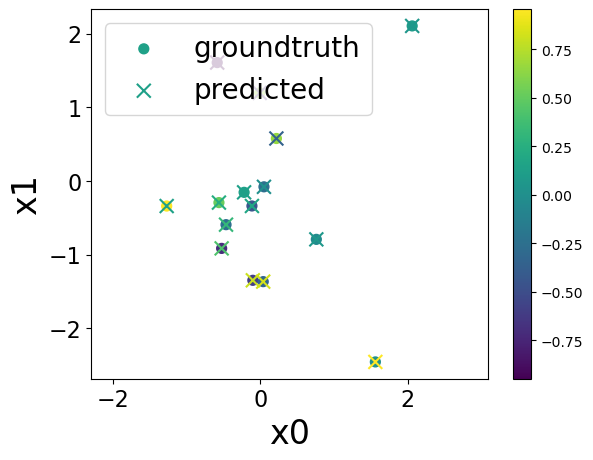

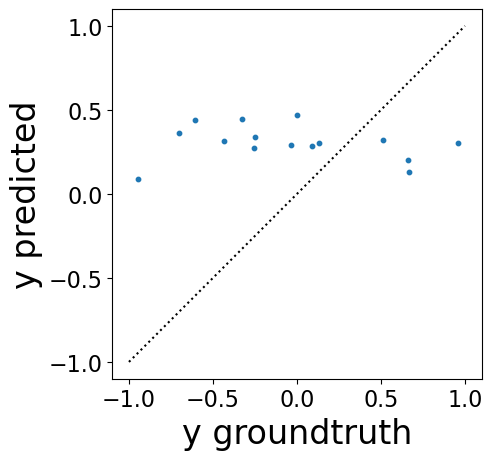

In [7]:
plot_pred_2d(x_val, y_gt_val, y_p_val)
plot_pred_vs_gt(y_gt_val, y_p_val)

## Training

We now train the neural network...

In [8]:
from numpy import reshape, transpose, sum, zeros, mean
from numpy.random import permutation
	
num_samples = len(x_train)
num_batches = 7
batch_size = int(num_samples / num_batches)
num_epochs = 10**4
eta = .1 # learning rate

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

mse_train = zeros((num_epochs,))
mse_val = zeros((num_epochs,))

for epoch in range(num_epochs):
	# permute samples
	permuted_order_samples = permutation(num_samples)
	x_permuted = x_train[permuted_order_samples]
	y_gt_permuted = y_gt_train[permuted_order_samples]
	
	for batch_start in range(0, num_samples, batch_size):
		dwa = zeros(wa.shape) # initialize weight increments layer 1
		dwb = zeros(wb.shape) # initialize weight increments layer 2

		for selected in range(batch_start, batch_start + batch_size):
			x_selected = reshape(x_permuted[selected], (1, -1))
			y_gt_selected = reshape(y_gt_permuted[selected], (1, -1))

			# detailed neural network calculation
			x_selected_a = x_selected # input layer 1
			p_a = x_selected_a @ wa # activation potential layer 1
			y_selected_a = sigmoid(p_a) # output layer 1
			
			x_selected_b = y_selected_a # input layer 2 (output neuron)
			p_b = x_selected_b @ wb # activation potential layer 2
			y_selected_b = p_b # output neuron layer 2

			y_p_selected = y_selected_b
			
			# update weight increments
			error = y_p_selected - y_gt_selected

			delta_b = error * 1
			dwb -= eta * delta_b * transpose(x_selected_b)

			delta_a = sum(wb * delta_b, axis=1) * d_sigmoid(p_a)
			dwa -= eta * delta_a * transpose(x_selected_a)

		wa += dwa / batch_size # update weights layer 1
		wb += dwb / batch_size # update weights layer 2

	y_p_train = sigmoid(x_train @ wa) @ wb
	mse_train[epoch] = mean((y_p_train - y_gt_train)**2)

	y_p_val = sigmoid(x_val @ wa) @ wb
	mse_val[epoch] = mean((y_p_val - y_gt_val)**2)

	print(f"{epoch} MSE train={mse_train[epoch]:.4f} val={mse_val[epoch]:.4f}")

0 MSE train=0.5564 val=0.3198
1 MSE train=0.5478 val=0.3508
2 MSE train=0.5403 val=0.3600
3 MSE train=0.5360 val=0.3486
4 MSE train=0.5407 val=0.4008
5 MSE train=0.5273 val=0.3658
6 MSE train=0.5251 val=0.3730
7 MSE train=0.5225 val=0.3859
8 MSE train=0.5211 val=0.3902
9 MSE train=0.5259 val=0.4164
10 MSE train=0.5308 val=0.3864
11 MSE train=0.5199 val=0.3914
12 MSE train=0.5169 val=0.4016
13 MSE train=0.5284 val=0.4379
14 MSE train=0.5152 val=0.4033
15 MSE train=0.5172 val=0.4182
16 MSE train=0.5222 val=0.3949
17 MSE train=0.5123 val=0.4058
18 MSE train=0.5151 val=0.4221
19 MSE train=0.5141 val=0.4205
20 MSE train=0.5112 val=0.4149
21 MSE train=0.5186 val=0.3936
22 MSE train=0.5077 val=0.4082
23 MSE train=0.5089 val=0.4142
24 MSE train=0.5054 val=0.4075
25 MSE train=0.5064 val=0.4139
26 MSE train=0.5032 val=0.4017
27 MSE train=0.5023 val=0.4023
28 MSE train=0.5009 val=0.3986
29 MSE train=0.4999 val=0.3981
30 MSE train=0.5046 val=0.4157
31 MSE train=0.4995 val=0.3875
32 MSE train=0.499

We can now plot the _mean squared error_ as a function of the training epoch using function `plot_mse()` now added to `plotting` for the training set (orange) and the validation set (green) using the function `plot_mse_train_vs_val`, which we add to `plotting`.

Its code is:
```python
def plot_mse_train_vs_val(mse_t, mse_v, smooth=11):
    import matplotlib.pyplot as plt
    from numpy import convolve, full

    mse_t_s = convolve(mse_t, full((smooth,), 1 / smooth), mode="valid")
    mse_v_s = convolve(mse_v, full((smooth,), 1 / smooth), mode="valid")

    fig, ax = plt.subplots(1, 2)
    
    fig.set_size_inches(10, 5)
    
    ax[0].plot(mse_t, c="tab:orange", label="train")
    ax[0].plot(mse_v, c="tab:green", label="validation")
    ax[0].plot(range(smooth // 2, len(mse_t) - smooth // 2), mse_t_s, c="k")
    ax[0].plot(range(smooth // 2, len(mse_v) - smooth // 2), mse_v_s, c="k")
    ax[0].legend()
    ax[0].set_xlabel("epoch", fontsize=24)
    ax[0].set_ylabel("MSE", fontsize=24)
    ax[0].tick_params(axis="both", which="major", labelsize=16)

    ax[1].loglog(mse_t, c="tab:orange", label="train")
    ax[1].loglog(mse_v, c="tab:green", label="validation")
    ax[1].loglog(range(smooth // 2, len(mse_v) - smooth // 2), mse_t_s, c="k")
    ax[1].loglog(range(smooth // 2, len(mse_v) - smooth // 2), mse_v_s, c="k")
    ax[1].legend()
    ax[1].set_xlabel("epoch", fontsize=24)
    ax[1].set_ylabel("MSE", fontsize=24)
    ax[1].tick_params(axis="both", which="major", labelsize=16)
    
    plt.tight_layout()
    plt.show()
```

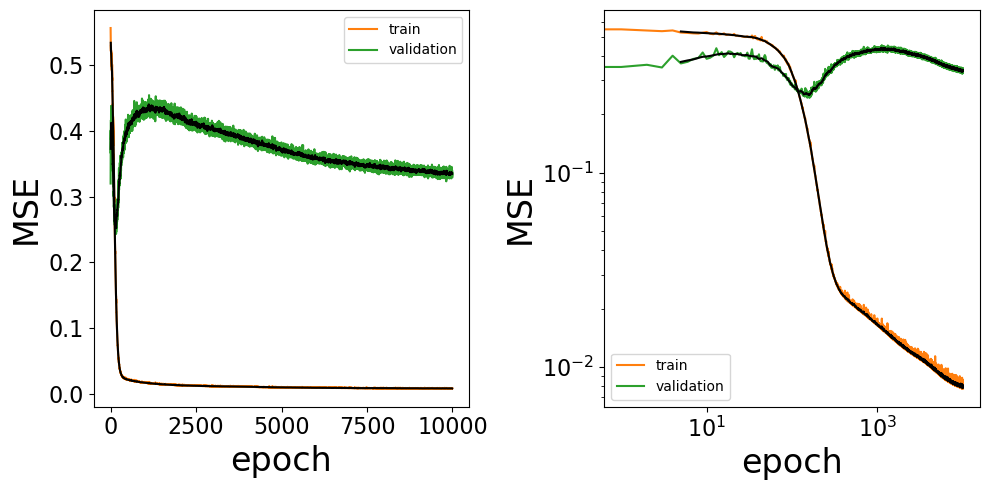

In [9]:
from plotting import plot_mse_train_vs_val

plot_mse_train_vs_val(mse_train, mse_val)

## Testing

We now check how the trained neuron works on the test data.

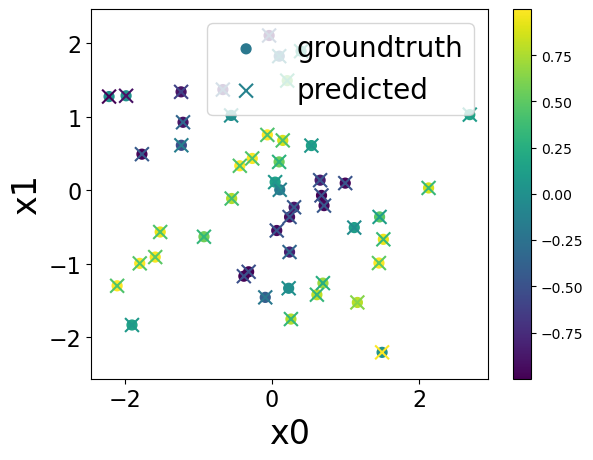

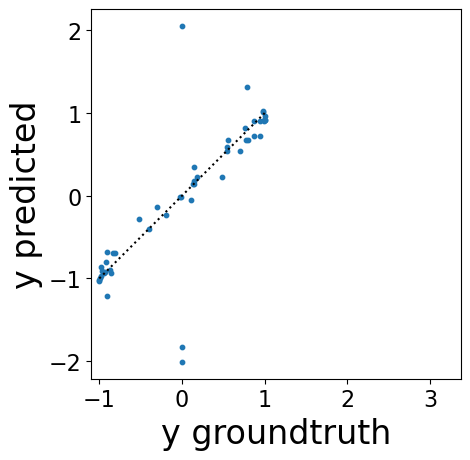

In [10]:
(x_test, y_gt_test) = load_data(filename="data_reg_2d_nonlinear_test.csv")

plot_pred_2d(x_test, y_gt_test, y_p=dnn2_reg(wa, wb, x_test))
plot_pred_vs_gt(y_gt_test, y_p=dnn2_reg(wa, wb, x_test))